# Dueling DQN

## About Dueling DQN

Dueling Deep Q Networks (DDQN) is a variant of Deep Q Networks (DQN), a popular deep reinforcement learning algorithm for solving problems in environments with discrete actions. The main difference between DDQN and DQN is the way the value of a state is estimated.

Like the standard DQN architecture, we have convolutional layers to process game-play frames. From there, we split the network into two separate streams, one for estimating the state-value and the other for estimating state-dependent action advantages. After the two streams, the last module of the network combines the state-value and advantage outputs.

<img src='pic/DDQN.png' alt="A2C" style='width: 700px;'/>

In a typical DQN algorithm, the value of a state is estimated by passing the state through a neural network and outputting a single value that represents the expected future reward for that state. However, this approach can be problematic in some cases because it can be difficult for the network to accurately represent both the value and the relative importance of each action in a state.

DDQN solves this problem by introducing two separate streams in the neural network: a value stream and an advantage stream. The value stream outputs a single value that represents the expected future reward for the state, while the advantage stream outputs the advantage of taking each action in the state. The final value of each action is then calculated by adding the value of the state to the advantage of the action. This allows the network to more accurately represent the value and relative importance of each action in a state, leading to improved performance in the reinforcement learning task.

In summary, DDQN is a variant of DQN that improves the estimation of state values by using a dueling network architecture that separates the value function into two streams: a value stream and an advantage stream. This allows the network to more accurately represent the value and relative importance of each action in a state, leading to improved performance in the reinforcement learning task.

## Library Imports

In [1]:
import numpy as np
import gym
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from collections import deque
import random
import sys
import numpy as np
import keras.backend as K
import pandas as pd
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, LSTM, Lambda
from keras.regularizers import l2

In [2]:
class ReplayBuffer:
    def __init__(self, size, input_shape):
        self.size = size
        self.counter = 0
        self.state_buffer = np.zeros((self.size, *input_shape), dtype=np.float32)
        self.action_buffer = np.zeros(self.size, dtype=np.int32)
        self.reward_buffer = np.zeros(self.size, dtype=np.float32)
        self.new_state_buffer = np.zeros((self.size, *input_shape), dtype=np.float32)
        self.terminal_buffer = np.zeros(self.size, dtype=np.bool_)

    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch]
        action_batch = self.action_buffer[batch]
        reward_batch = self.reward_buffer[batch]
        new_state_batch = self.new_state_buffer[batch]
        done_batch = self.terminal_buffer[batch]

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch

In [3]:
class DuelingDQN(keras.Model):
    def __init__(self, num_actions, fc1, fc2):
        super(DuelingDQN, self).__init__()
        self.dense1 = Dense(fc1, activation='relu')
        self.dense2 = Dense(fc2, activation='relu')
        self.V = Dense(1, activation=None)
        self.A = Dense(num_actions, activation=None)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)
        avg_A = tf.math.reduce_mean(A, axis=1, keepdims=True)
        Q = (V + (A - avg_A))

        return Q, A


class Agent:
    def __init__(self, lr, discount_factor, num_actions, epsilon, batch_size, input_dim):
        self.action_space = [i for i in range(num_actions)]
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epsilon_decay = 0.001
        self.epsilon_final = 0.01
        self.update_rate = 120
        self.step_counter = 0
        self.buffer = ReplayBuffer(100000, input_dim)
        self.q_net = DuelingDQN(num_actions, 128, 128)
        self.q_target_net = DuelingDQN(num_actions, 128, 128)
        self.q_net.compile(optimizer=Adam(learning_rate=lr), loss='mse')
        self.q_target_net.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    def store_tuple(self, state, action, reward, new_state, done):
        self.buffer.store_tuples(state, action, reward, new_state, done)

    def policy(self, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation])
            _, actions = self.q_net(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    def train(self):
        if self.buffer.counter < self.batch_size:
            return
        if self.step_counter % self.update_rate == 0:
            self.q_target_net.set_weights(self.q_net.get_weights())

        state_batch, action_batch, reward_batch, new_state_batch, done_batch = \
            self.buffer.sample_buffer(self.batch_size)

        q_predicted, _ = self.q_net(state_batch)
        q_next, _ = self.q_target_net(new_state_batch)
        q_max_next = tf.math.reduce_max(q_next, axis=1, keepdims=True).numpy()
        q_target = np.copy(q_predicted)

        for idx in range(done_batch.shape[0]):
            target_q_val = reward_batch[idx]
            if not done_batch[idx]:
                target_q_val += self.discount_factor*q_max_next[idx]
            q_target[idx, action_batch[idx]] = target_q_val
        self.q_net.train_on_batch(state_batch, q_target)
        self.epsilon = self.epsilon - self.epsilon_decay if self.epsilon > self.epsilon_final else self.epsilon_final
        self.step_counter += 1

    def train_model(self, env, num_episodes, graph):

        scores, episodes, avg_scores, obj = [], [], [], []
        goal = 200
        f = 0
        txt = open("saved_networks.txt", "w")

        for i in range(num_episodes):
            done = False
            score = 0.0
            state = env.reset()
            while not done:
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                score += reward
                self.store_tuple(state, action, reward, new_state, done)
                state = new_state
                self.train()
            scores.append(score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)
            print("Episode {0}/{1}, Score: {2} ({3}), AVG Score: {4}".format(i, num_episodes, score, self.epsilon,
                                                                             avg_score))
            if avg_score >= 200.0 and score >= 250:
                self.q_net.save(("saved_networks/duelingdqn_model{0}".format(f)))
                self.q_net.save_weights(("saved_networks/duelingdqn_model{0}/net_weights{0}.h5".format(f)))
                txt.write("Save {0} - Episode {1}/{2}, Score: {3} ({4}), AVG Score: {5}\n".format(f, i, num_episodes,
                                                                                                  score, self.epsilon,
                                                                                                  avg_score))
                f += 1
                print("Network saved")

        txt.close()
        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': scores, 'Average Score': avg_scores, 'Solved Requirement': obj})

            plt.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
            plt.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                     label='AverageScore')
            plt.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                     label='Solved Requirement')
            plt.legend()
            plt.savefig('LunarLander_Train.png')

    def test(self, env, num_episodes, file_type, file, graph):
        if file_type == 'tf':
            self.q_net = tf.keras.models.load_model(file)
        elif file_type == 'h5':
            self.train_model(env, 5, False)
            self.q_net.load_weights(file)
        self.epsilon = 0.0
        scores, episodes, avg_scores, obj = [], [], [], []
        goal = 200
        score = 0.0
        for i in range(num_episodes):
            state = env.reset()
            done = False
            episode_score = 0.0
            while not done:
                env.render()
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                episode_score += reward
                state = new_state
            score += episode_score
            scores.append(episode_score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)

        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': scores, 'Average Score': avg_scores, 'Solved Requirement': obj})

            plt.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
            plt.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                     label='AverageScore')
            plt.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                     label='Solved Requirement')
            plt.legend()
            plt.savefig('LunarLander_Test.png')

        env.close()

Episode 0/1000, Score: -161.06417718525552 (0.981), AVG Score: -161.06417718525552
Episode 1/1000, Score: -102.58549830032665 (0.9259999999999999), AVG Score: -131.8248377427911
Episode 2/1000, Score: -199.56510069622504 (0.8429999999999999), AVG Score: -154.40492539393574
Episode 3/1000, Score: -175.7982292665663 (0.7399999999999998), AVG Score: -159.75325136209338
Episode 4/1000, Score: -72.89895106696298 (0.6759999999999997), AVG Score: -142.3823913030673
Episode 5/1000, Score: -262.88149331485164 (0.5729999999999996), AVG Score: -162.46557497169803
Episode 6/1000, Score: -213.98244880296497 (0.47599999999999953), AVG Score: -169.8251283761647
Episode 7/1000, Score: -264.76884410639866 (0.3449999999999994), AVG Score: -181.69309284244397
Episode 8/1000, Score: -276.0434111162286 (0.27599999999999936), AVG Score: -192.17646153953115
Episode 9/1000, Score: -819.2504104892032 (0.048999999999999155), AVG Score: -254.88385643449837
Episode 10/1000, Score: -273.48963942787805 (0.01), AVG 

Episode 99/1000, Score: -226.87736626078762 (0.01), AVG Score: -196.96542558996072
Episode 100/1000, Score: -276.1636455889501 (0.01), AVG Score: -198.11642027399768
Episode 101/1000, Score: -150.39305648077806 (0.01), AVG Score: -198.5944958558022
Episode 102/1000, Score: -172.0106071031817 (0.01), AVG Score: -198.31895091987175
Episode 103/1000, Score: -235.92183532781718 (0.01), AVG Score: -198.9201869804842
Episode 104/1000, Score: -372.04085379295026 (0.01), AVG Score: -201.91160600774413
Episode 105/1000, Score: -115.45363170200991 (0.01), AVG Score: -200.4373273916157
Episode 106/1000, Score: -289.80327829018336 (0.01), AVG Score: -201.1955356864879
Episode 107/1000, Score: -96.39219428149191 (0.01), AVG Score: -199.51176918823884
Episode 108/1000, Score: -352.6512465558567 (0.01), AVG Score: -200.2778475426351
Episode 109/1000, Score: -109.78541043268274 (0.01), AVG Score: -193.1831975420699
Episode 110/1000, Score: -92.05554243943887 (0.01), AVG Score: -191.36885657218554
Epis

Episode 198/1000, Score: -27.646777741059026 (0.01), AVG Score: -124.46734236370206
Episode 199/1000, Score: -40.89091704116489 (0.01), AVG Score: -122.60747787150582
Episode 200/1000, Score: -13.40905346406247 (0.01), AVG Score: -119.97993195025694
Episode 201/1000, Score: -132.74486613786505 (0.01), AVG Score: -119.80345004682782
Episode 202/1000, Score: -162.4875988394814 (0.01), AVG Score: -119.70821996419082
Episode 203/1000, Score: -170.31268963728877 (0.01), AVG Score: -119.05212850728553
Episode 204/1000, Score: -181.3341743367872 (0.01), AVG Score: -117.14506171272392
Episode 205/1000, Score: -27.974792169269744 (0.01), AVG Score: -116.2702733173965
Episode 206/1000, Score: -166.1632778386776 (0.01), AVG Score: -115.03387331288144
Episode 207/1000, Score: -191.84881675160335 (0.01), AVG Score: -115.98843953758255
Episode 208/1000, Score: -28.437659081092576 (0.01), AVG Score: -112.7463036628349
Episode 209/1000, Score: -69.36873124653856 (0.01), AVG Score: -112.34213687097346


Episode 298/1000, Score: -31.113526347502017 (0.01), AVG Score: -14.774898374894114
Episode 299/1000, Score: 215.2115218432093 (0.01), AVG Score: -12.213873986050372
Episode 300/1000, Score: -40.726157431730954 (0.01), AVG Score: -12.48704502572706
Episode 301/1000, Score: 237.16679425991526 (0.01), AVG Score: -8.787928421749255
Episode 302/1000, Score: 250.94534213581565 (0.01), AVG Score: -4.653599011996286
Episode 303/1000, Score: 274.90089986256294 (0.01), AVG Score: -0.20146311699776676
Episode 304/1000, Score: 15.184338935534342 (0.01), AVG Score: 1.763722015725449
Episode 305/1000, Score: 249.50023239631832 (0.01), AVG Score: 4.538472261381331
Episode 306/1000, Score: -134.72471485222025 (0.01), AVG Score: 4.852857891245905
Episode 307/1000, Score: 250.6103253095389 (0.01), AVG Score: 9.277449311857326
Episode 308/1000, Score: -49.88925960457829 (0.01), AVG Score: 9.062933306622469
Episode 309/1000, Score: -83.76799243192649 (0.01), AVG Score: 8.918940694768589
Episode 310/1000,

Episode 399/1000, Score: 216.58179224654037 (0.01), AVG Score: 162.68777035463827
Episode 400/1000, Score: 289.9239139728506 (0.01), AVG Score: 165.9942710686841
Episode 401/1000, Score: 263.06138030122935 (0.01), AVG Score: 166.25321692909725
Episode 402/1000, Score: 290.901133448384 (0.01), AVG Score: 166.65277484222293
Episode 403/1000, Score: 239.69923296810197 (0.01), AVG Score: 166.3007581732783
Episode 404/1000, Score: 231.36680405455328 (0.01), AVG Score: 168.46258282446848
Episode 405/1000, Score: 260.19527238789846 (0.01), AVG Score: 168.56953322438426
Episode 406/1000, Score: 233.653108811523 (0.01), AVG Score: 172.25331146102172
Episode 407/1000, Score: 263.674474418738 (0.01), AVG Score: 172.38395295211367
Episode 408/1000, Score: 231.80587086617854 (0.01), AVG Score: 175.20090425682127
Episode 409/1000, Score: 215.8060585209313 (0.01), AVG Score: 178.19664476634986
Episode 410/1000, Score: 267.1051315291828 (0.01), AVG Score: 181.53307654174247
Episode 411/1000, Score: 26

INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model21\assets
Network saved
Episode 477/1000, Score: 244.77696171151132 (0.01), AVG Score: 226.5721014618057
Episode 478/1000, Score: 281.01447905189195 (0.01), AVG Score: 227.41775928508417
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model22\assets
Network saved
Episode 479/1000, Score: 254.5312557107244 (0.01), AVG Score: 230.38465565336588
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model23\assets
Network saved
Episode 480/1000, Score: 256.5758642362904 (0.01), AVG Score: 230.76147756663224
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model24\assets
Network saved
Episode 481/1000, Score: 245.9434736703752 (0.01), AVG Score: 230.72504111509832
Episode 482/1000, Score: 288.91919096425556 (0.01), AVG Score: 231.56651604478432
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model25\assets
Network saved
Episode 483/1000, Score: 249.99909232299734 (0.01), AVG Score:

Network saved
Episode 535/1000, Score: 248.70494683429806 (0.01), AVG Score: 220.17920093358273
Episode 536/1000, Score: 272.3635422517626 (0.01), AVG Score: 220.6879342436543
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model60\assets
Network saved
Episode 537/1000, Score: 277.85739327997555 (0.01), AVG Score: 220.70320228225583
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model61\assets
Network saved
Episode 538/1000, Score: 259.1082582319327 (0.01), AVG Score: 220.71442594129974
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model62\assets
Network saved
Episode 539/1000, Score: 235.8935591593049 (0.01), AVG Score: 220.59030975509006
Episode 540/1000, Score: 25.280061023067773 (0.01), AVG Score: 218.36757116599256
Episode 541/1000, Score: 31.487511220891662 (0.01), AVG Score: 217.24350658858623
Episode 542/1000, Score: 242.34685926959918 (0.01), AVG Score: 216.94884752179146
Episode 543/1000, Score: 246.98117094025594 (0.01), AVG Score: 2

Network saved
Episode 596/1000, Score: 257.28236923935646 (0.01), AVG Score: 226.2865199834882
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model96\assets
Network saved
Episode 597/1000, Score: 280.4208714182351 (0.01), AVG Score: 226.16995980052872
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model97\assets
Network saved
Episode 598/1000, Score: 270.39730847595206 (0.01), AVG Score: 226.39149995320346
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model98\assets
Network saved
Episode 599/1000, Score: 237.7071488482232 (0.01), AVG Score: 226.17660602813726
Episode 600/1000, Score: 270.65515305596296 (0.01), AVG Score: 226.20433714542355
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model99\assets
Network saved
Episode 601/1000, Score: 281.9876830589445 (0.01), AVG Score: 226.12631444343376
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model100\assets
Network saved
Episode 602/1000, Score: 267.6761811410089 (0.0

Episode 652/1000, Score: 276.35696969768605 (0.01), AVG Score: 245.82433927985446
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model136\assets
Network saved
Episode 653/1000, Score: 249.03941084188466 (0.01), AVG Score: 245.96054724942445
Episode 654/1000, Score: 245.6861004575689 (0.01), AVG Score: 245.40288229361374
Episode 655/1000, Score: 267.7301064349706 (0.01), AVG Score: 245.47407422159992
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model137\assets
Network saved
Episode 656/1000, Score: 230.1288458564751 (0.01), AVG Score: 245.09018122498546
Episode 657/1000, Score: 263.96586749023976 (0.01), AVG Score: 244.77028800916975
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model138\assets
Network saved
Episode 658/1000, Score: 220.2098414474986 (0.01), AVG Score: 244.59534971840566
Episode 659/1000, Score: 298.06527102815164 (0.01), AVG Score: 245.11285099347052
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model139\asset

Network saved
Episode 713/1000, Score: 248.49292307581825 (0.01), AVG Score: 242.99761874842
Episode 714/1000, Score: 242.94471999582842 (0.01), AVG Score: 242.63208315888357
Episode 715/1000, Score: 166.74815591965668 (0.01), AVG Score: 241.91325544556625
Episode 716/1000, Score: 239.49039276634207 (0.01), AVG Score: 241.80372331118502
Episode 717/1000, Score: 247.42863444474034 (0.01), AVG Score: 241.346066150631
Episode 718/1000, Score: 258.3484620038818 (0.01), AVG Score: 241.34592617661872
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model172\assets
Network saved
Episode 719/1000, Score: 198.9001886049853 (0.01), AVG Score: 242.23790592203974
Episode 720/1000, Score: 315.27873628323573 (0.01), AVG Score: 243.15873103711795
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model173\assets
Network saved
Episode 721/1000, Score: 236.46166378077513 (0.01), AVG Score: 243.1387245402463
Episode 722/1000, Score: 280.8086924058556 (0.01), AVG Score: 243.67272661

INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model207\assets
Network saved
Episode 775/1000, Score: 304.49760273718516 (0.01), AVG Score: 243.57989849355923
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model208\assets
Network saved
Episode 776/1000, Score: 259.8382814660249 (0.01), AVG Score: 244.07012648520544
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model209\assets
Network saved
Episode 777/1000, Score: 266.9039411003374 (0.01), AVG Score: 246.53833323814703
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model210\assets
Network saved
Episode 778/1000, Score: 270.0001800147489 (0.01), AVG Score: 247.0007372849401
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model211\assets
Network saved
Episode 779/1000, Score: 209.16163472740638 (0.01), AVG Score: 247.7128688837596
Episode 780/1000, Score: 237.41802902106966 (0.01), AVG Score: 248.00748038500683
Episode 781/1000, Score: 265.9044481097099 (0.01), AVG Sco

Network saved
Episode 827/1000, Score: -211.0633574911272 (0.01), AVG Score: 245.43495019543155
Episode 828/1000, Score: 289.6940751596822 (0.01), AVG Score: 245.69879796155942
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model251\assets
Network saved
Episode 829/1000, Score: 260.74934687830455 (0.01), AVG Score: 245.24276542139057
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model252\assets
Network saved
Episode 830/1000, Score: 254.89899201567326 (0.01), AVG Score: 245.25633882951507
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model253\assets
Network saved
Episode 831/1000, Score: -228.04312883177536 (0.01), AVG Score: 240.8219581346496
Episode 832/1000, Score: 250.2851050433469 (0.01), AVG Score: 240.27151567031657
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model254\assets
Network saved
Episode 833/1000, Score: 264.6627470769758 (0.01), AVG Score: 240.24601160600218
INFO:tensorflow:Assets written to: saved_networks/d

INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model290\assets
Network saved
Episode 885/1000, Score: 239.8395988255557 (0.01), AVG Score: 240.93984247460213
Episode 886/1000, Score: 270.3968985724666 (0.01), AVG Score: 240.9463841794964
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model291\assets
Network saved
Episode 887/1000, Score: 258.205595684178 (0.01), AVG Score: 240.66160626511063
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model292\assets
Network saved
Episode 888/1000, Score: 208.77095987136994 (0.01), AVG Score: 239.94283600160298
Episode 889/1000, Score: 228.16217752184227 (0.01), AVG Score: 239.4870648594939
Episode 890/1000, Score: 248.22884669048173 (0.01), AVG Score: 239.04546232183722
Episode 891/1000, Score: 236.15017348111434 (0.01), AVG Score: 238.47819583740562
Episode 892/1000, Score: 266.5348032901019 (0.01), AVG Score: 238.39123524395046
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model293\assets
N

INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model332\assets
Network saved
Episode 939/1000, Score: 272.4217496777386 (0.01), AVG Score: 252.3246506361854
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model333\assets
Network saved
Episode 940/1000, Score: 254.7073749884839 (0.01), AVG Score: 252.06576368274
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model334\assets
Network saved
Episode 941/1000, Score: 294.38007363817474 (0.01), AVG Score: 255.03976802755096
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model335\assets
Network saved
Episode 942/1000, Score: 260.02354384698003 (0.01), AVG Score: 255.2057461928006
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model336\assets
Network saved
Episode 943/1000, Score: 279.0493713350647 (0.01), AVG Score: 255.34953633202986
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model337\assets
Network saved
Episode 944/1000, Score: 255.66695328417936 (0.01), 

Network saved
Episode 994/1000, Score: 238.32151875601716 (0.01), AVG Score: 241.66908921299932
Episode 995/1000, Score: 271.7934881950054 (0.01), AVG Score: 241.46066413883753
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model374\assets
Network saved
Episode 996/1000, Score: 298.1279656677883 (0.01), AVG Score: 241.64220691470953
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model375\assets
Network saved
Episode 997/1000, Score: 311.79038824813784 (0.01), AVG Score: 241.78218413717747
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model376\assets
Network saved
Episode 998/1000, Score: 278.6778819067906 (0.01), AVG Score: 241.7928048004972
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model377\assets
Network saved
Episode 999/1000, Score: 280.78902630406446 (0.01), AVG Score: 241.48911222424925
INFO:tensorflow:Assets written to: saved_networks/duelingdqn_model378\assets
Network saved


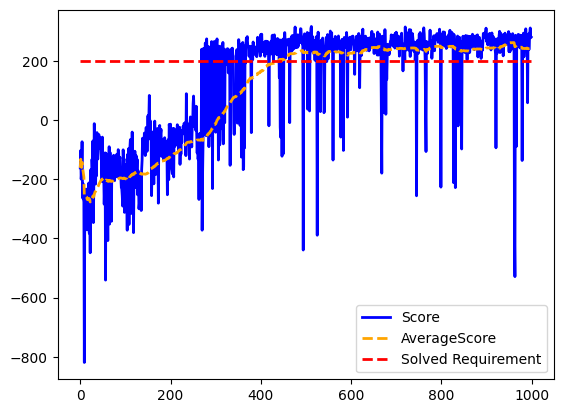

In [4]:
env = gym.make("LunarLander-v2")
spec = gym.spec("LunarLander-v2")
train = True
test = False
num_episodes = 1000
graph = True

file_type = 'tf'
file = 'saved_networks/duelingdqn_model123'

duelingdqn_agent = Agent(lr=0.00075, discount_factor=0.99, num_actions=4, epsilon=1.0, batch_size=64, input_dim=[8])

if train and not test:
    duelingdqn_agent.train_model(env, num_episodes, graph)
else:
    duelingdqn_agent.test(env, num_episodes, file_type, file, graph)

From the plot above we can see that deuling DQN performs well on LunarLanderV2, after around 290 episodes the average score/reward is consistently above the solved requirement.